For this demonstration we will be simulating a SrTiO3 CeO2 interface downloaded from https://www.materialscloud.org/explore/stoceriaitf/grid/calculations (slow) or just good ol' silicon (faster). The SrTiO3-CeO2 interface takes 1 hour 15 minutes and the silicon example takes 5 min per frozen phonon iteration on my NVIDIA GTX 750Ti.

In [5]:
import pyms
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

# Get crystal

# crystal = pyms.structure.fromfile('Structures/SrTiO3_CeO2_interface.xyz')

# A few maniupulations to remove vaccuum at edges and create a 
# structure psuedo-periodic
# crystal = crystal.resize([[0.1,0.76]],axis=[0])
# crystal = crystal.concatenate(crystal.resize([[0.017,0.99]],
#                                     axis=[0]).reflect([0]),axis=0)

# Output structure for examination in Vesta 
# crystal.output_vesta_xtl('manipulated_SrTiO3_CeO2_interface.xtl')
# tiling = [1,7]

# Note that we have to be careful that we specify the units of
# the atomic coordinates (cartesian in this case not the default fractional units)
# and the temperature factor units (root mean squared displacement - urms)
crystal = pyms.structure.fromfile('Structures/Si100.xyz',atomic_coordinates='cartesian',temperature_factor_units='urms')
crystal.output_vesta_xtl('Si100.xtl')
tiling = [8,8]

# Subslicing of crystal for multislice
nslices = int(np.ceil(crystal.unitcell[2]/2))
subslices = np.linspace(1.0/nslices,1.0,nslices)
nsubslices = len(subslices)

# Set up thickness series
tstep = 100
thicknesses = np.asarray([50,100, 200])

# Grid size in pixels
# If you're doing the SrTiO3-CeO2 interface then  for converged, 
# publication-quality results this gridshape should be doubled
gridshape = [1024,1024]

# Probe accelerating voltage in eV
eV = 3e5

# Probe-forming aperture in mrad
app = 15

# Define detector inner and outer angles
# in order, a central bright-field detector, an annular 
# bright-field (ABF) detector and a high-angle annular
# dark-field (HAADF) detector
detectors = [[0,app/2], [app/2,app],[70,150]]

# If only 4D-STEM is requested set detectors to be None
# detectors = None

# Number of frozen phonon passes
# Number typically required for a converged experiment
# nfph = 25
# Number required for a brief run-time
nfph = 5

# 4D-STEM options:

# No 4D-STEM
FourDSTEM = False

# 4D-STEM with diffraction pattern sizing set by
# multislice grid
# FourDSTEM = True

# 4D-STEM with diffraction patterns cropped to
# 128x128 pixel readout
FourDSTEM = [[128,128]]

# 4D-STEM with diffraction patterns cropped to
# 128x128 pixel readout with diffraction space
# dimensions of 3 inverse Angstrom
# FourDSTEM = [[128,128],[3.0,3.0]]

# Probe defocus, an array can be provided for a defocus series
# df = np.arange(-200,300,50)
df = 0

# Option for more control over the device which performs the 
# calculation.
# GPU (CUDA) calculation
device = torch.device('cuda')
# Run calculation on your computer's second GPU
# device = torch.device('cuda:1')
# CPU only calculation
# device = torch.device('cpu')

print('Max resolution permitted by the sample grid is {0} mrad'.format(pyms.max_grid_resolution(gridshape,np.asarray(tiling)*crystal.unitcell[:2],eV=eV)))



Max resolution permitted by the sample grid is 154.69603989397606 mrad


In [6]:
result = pyms.STEM_multislice(
    crystal,
    gridshape,
    eV,
    app,
    thicknesses,
    subslices=subslices,
    device_type=device,
    df=0,
    nfph=nfph,
    FourD_STEM=FourDSTEM,
    PACBED=True,
    tiling=tiling,
    detector_ranges=detectors,
    showProgress='notebook',
    h5_filename = ['Si_t={0:04d}.h5'.format(t) for t in thicknesses]
)

Now plot STEM images and output datacube into a py4DSTEM (https://github.com/py4dstem/py4DSTEM) friendly format

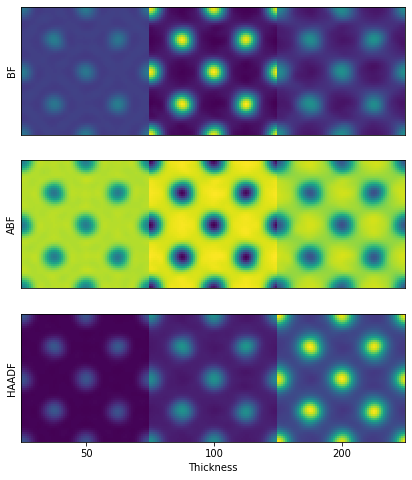

In [7]:
# Plot STEM images
if detectors is not None:
    interp_shape = [64,64]
    fig,axes = plt.subplots(figsize=(8,8),nrows = result['STEM images'].shape[0])
    interp = pyms.utils.fourier_interpolate_2d(result['STEM images'],interp_shape)

    for i,ax in enumerate(axes):
        ax.imshow(np.hstack(interp[i]))
        ax.set_ylabel(['BF','ABF','HAADF'][i])
        ax.set_yticks([])
        ax.set_xticks([])



    ax.set_xticks(np.arange(interp_shape[1]/2,interp_shape[1]*len(thicknesses)+1,interp_shape[1]))
    ax.set_xticklabels(thicknesses)
    ax.set_xlabel('Thickness')
    plt.show()

Now simulate a larger field of view: a SrTiO$_3$-CeO$_2$ interface using the PRISM algorithm

In [8]:
import pyms

# The PRISM algorithm can only a single thickness at a time
thickness = 100
torch.cuda.empty_cache()

crystal = pyms.structure.fromfile('Structures/SrTiO3_CeO2_interface.xyz',atomic_coordinates='cartesian')

# A few maniupulations to remove vaccuum at edges and create a 
# structure that is psuedo-periodic
crystal = crystal.resize([[0.1,0.76]],axis=[0])
crystal = crystal.concatenate(crystal.resize([[0.017,0.99]],
                                    axis=[0]).reflect([0]),axis=0)

# Output structure for examination in Vesta 
# crystal.output_vesta_xtl('manipulated_SrTiO3_CeO2_interface.xtl')
tiling = [1,7]
subslices = 0.07 *np.arange(14)
subslices[-1] = 1.0
# For a converged calculation this should be > 5 
nfph = 1

# PRISM interpolation factor,should be about [2,2] for a converged calculation
# depending on the size of your graphics card it might need to be a bit larger
# to fit the calculation (a larger PRISM factor requires less memory and runs 
# faster with a penalty to accuracy)
PRISM_factor = [4,4]

result = pyms.STEM_PRISM(
    crystal,
    gridshape,
    eV,
    app,
    thickness,
    nfph=nfph,
    subslices=subslices,
    device_type=device,
    df=0,
    tiling=tiling,
    detector_ranges=detectors,
    PRISM_factor = PRISM_factor
    showProgress= 'notebook'
)

Probe position clusters: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


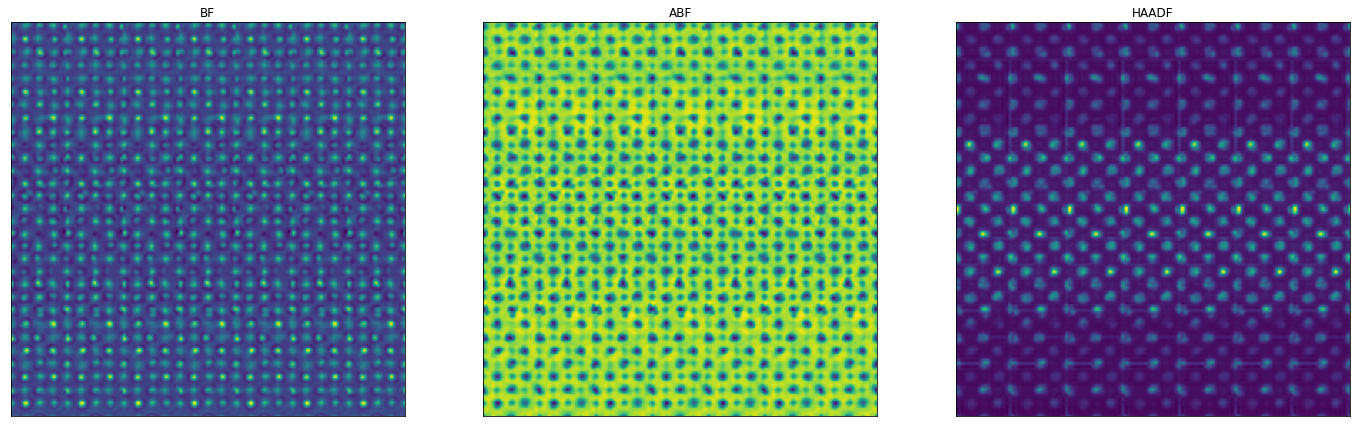

In [16]:
# Plot STEM images
if detectors is not None:
    interp_shape = [512,512]
    ncols = result['STEM images'].shape[0]
    fig,axes = plt.subplots(figsize=(8*ncols,8),ncols = ncols)
    interp = pyms.utils.fourier_interpolate_2d(np.tile(result['STEM images'],tiling),interp_shape)

    for i,ax in enumerate(axes):
        ax.imshow(interp[i])
        ax.set_title(['BF','ABF','HAADF'][i])
        ax.set_yticks([])
        ax.set_xticks([])



#     ax.set_xticks(np.arange(interp_shape[1]/2,interp_shape[1]*len(thicknesses)+1,interp_shape[1]))
#     ax.set_xticklabels(thicknesses)
#     ax.set_xlabel('Thickness')
    plt.show()